# Classification of Technical Articles

### OBJECTIVE : 
The objective of this project is to determine whether or not, a set of articles can be classified or clustered into categories.
### About Dataset:
Deskdrop is a collaboration tool that allows employees to communicate and interact with colleagues by interacting with articles. This dataset comprises of data from the DeskDrop Platform
We have two datasets as follows:

<br><b> 1.	Shared Articles </b>
This dataset contains information about the articles that have been shared on the platform. It has informatin like the published data, URL of the article, title, content and the language of the article.

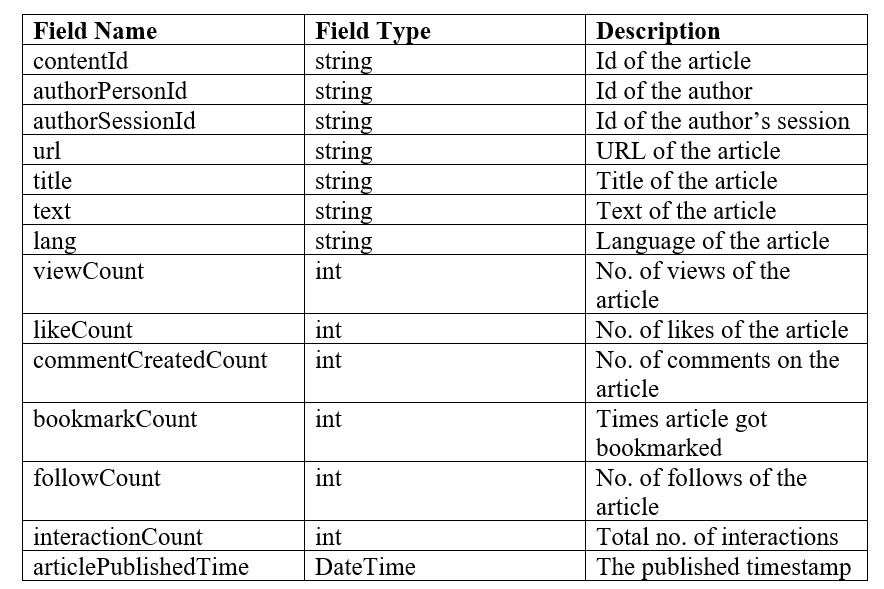

<br><b> 2.	User Interactions</b>
This dataset comprises all logs of the user’s interaction with the article. The information of the user such as users’s country, region, ID and which device they are using to open the article. It also has information about the type of interaction as well.
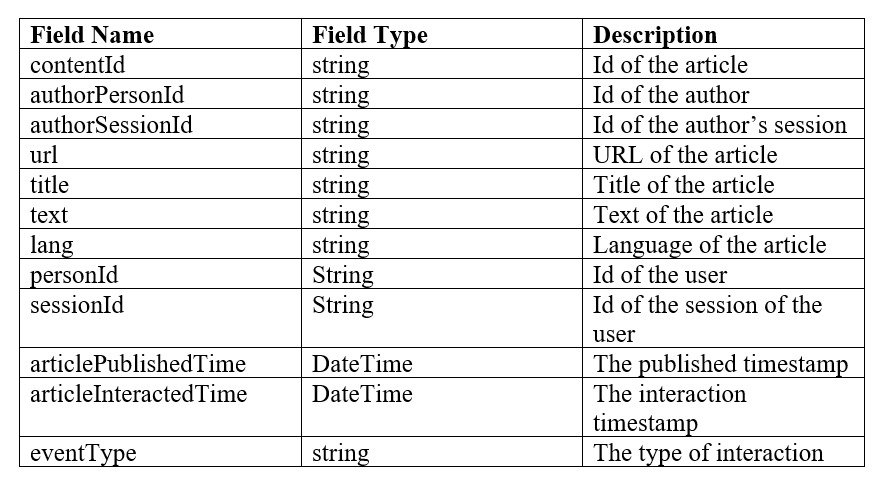
***
<b>Target Variable</b>: CategoryID (for Supervised) and ClusterIndex (for Unsupervised)
<b>Input variables</b>: title, text

In [71]:
# Importing Libraries
import pydot
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objects as go
from datetime import datetime
from IPython.display import Image
from IPython.display import display
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, similarities
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn import metrics
import itertools
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

We have two csv files namely ‘shared_articles.csv’ and ‘user_interactions.csv’. The following codes reads the original datasets :

In [72]:
#Shared Articles Dataset
articlesDF = pd.read_csv(r'C:\\Users\\cskar\\OneDrive\\Documents\\GitHub\\MachineLearningWithPython\\shared_articles.csv')
#User Interactions Dataset
interactionsDF = pd.read_csv(r'C:\\Users\\cskar\\OneDrive\\Documents\\GitHub\\\MachineLearningWithPython\\users_interactions.csv')

### Questions to be answered:

1.How can we classify the articles based on their category? 
 
2.Can we predict the category of the unknown articles with higher precision and accuracy?
    
3.What are the models to be implemented and why are they suitable?

In [73]:
articlesDF.dtypes

timestamp           int64
eventType          object
contentId           int64
authorPersonId      int64
authorSessionId     int64
authorUserAgent    object
authorRegion       object
authorCountry      object
contentType        object
url                object
title              object
text               object
lang               object
dtype: object

In [74]:
interactionsDF.dtypes

timestamp       int64
eventType      object
contentId       int64
personId        int64
sessionId       int64
userAgent      object
userRegion     object
userCountry    object
dtype: object

## Business Understanding:

There are many ways an article classification and clustering model can be used. The below chart explains about how classification and clustering are so effective for the business:

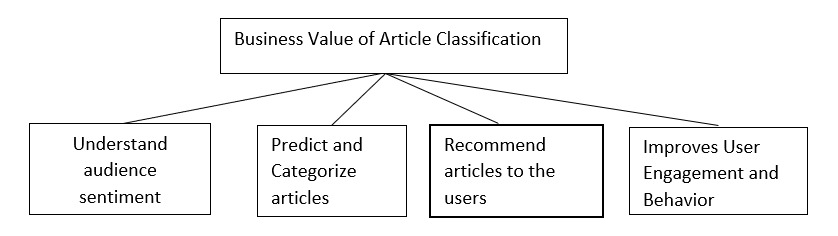

## Data Preparation and Exploratory Data Analysis

### 1.	Correction in Data Types:
Since IDs are in number form, the data was read as type int64 but all the IDs namely, contentId, authorPersonId, authorSessionId, personId, sessionId are of text type so they are converted to string as the first step in data cleaning.

In [75]:
articlesDF.contentId = articlesDF.contentId.astype(str)
articlesDF.authorPersonId = articlesDF.authorPersonId.astype(str)
articlesDF.authorSessionId = articlesDF.authorSessionId.astype(str)
articlesDF.shape

(3122, 13)

In [76]:
interactionsDF.contentId = interactionsDF.contentId.astype(str)
interactionsDF.personId = interactionsDF.personId.astype(str)
interactionsDF.sessionId = interactionsDF.sessionId.astype(str)
interactionsDF.shape

(72312, 8)

### 2.	Deletion of removed articles from the dataframes(CONTENT REMOVED):
There are two types of articles, (‘CONTENT SHARED’,’CONTENT REMOVED’) in the datasets which is explained by the ‘eventType’ column in the Shared article dataset. Since we cannot use removed articles for prediction and categorization, we remove them from both User interactions and Shared article datasets.

In [77]:
# CONTENT REMOVED JUST HAS 75 ENTRIES AND IS CONTENT THAT IS NO LONGER ACCESSIBLE WISE TO DELETE
deletedContentID =articlesDF.contentId[articlesDF.eventType == 'CONTENT REMOVED']
articlesDF = articlesDF[articlesDF.eventType == 'CONTENT SHARED']
articlesDF.drop('eventType', axis=1, inplace=True)
interactionsDF = interactionsDF[~interactionsDF.contentId.isin(deletedContentID)]

### 3.	Renaming column names before merging dataframes:
Since we have timestamp in both dataframe and each timestamp means something different, we rename the timestamp column in dataframes before merging.

In [78]:
#before joining rename similar name columns
articlesDF.rename(inplace = True, columns={"timestamp":"articlePublishedTime"})
interactionsDF.rename(inplace=True, columns={"timestamp": "articleInteractedTime"})

In [79]:
pie_chart = go.Figure()
aLabels = articlesDF['contentType'].value_counts().index
aValues = articlesDF['contentType'].value_counts().values
pie_chart.add_trace(go.Pie(labels=aLabels,values=aValues))
pie_chart.update_traces(textposition='outside', textinfo='percent+label',\
                               marker=dict(colors=['darkorange','gold','red'], line=dict(color='#000000', width=2)))
pie_chart.update_layout(height=500, width=800, title_text="Distributed Type of Content")
pie_chart.show()

#### Observations
- HTML Type is the dominating type of content with almost all articles i.e. 99.3% of the data.
- We can safely remove RICH and VIDEO types since the comprise of a smaller percentage of data

### 4.	Removal of contentType feature from Shared article dataset :
There are articles of three types of content, namely, HTML, RICH, VIDEO. We will remove RICH and VIDEO type since they comprise of a very small percentage of data.

In [80]:
#Delete contents which are not of HTML type and make sure we have the interactions only for those contents which are present
deletedContentID =articlesDF.contentId[articlesDF.contentType != 'HTML']
articlesDF = articlesDF[articlesDF.contentType == 'HTML']
articlesDF.drop('contentType', axis=1, inplace=True)
interactionsDF = interactionsDF[~interactionsDF.contentId.isin(deletedContentID)]

In [81]:
langPie = go.Figure()
aLabels = articlesDF['lang'].value_counts().index
aValues = articlesDF['lang'].value_counts().values
langPie.add_trace(go.Pie(labels=aLabels, values=aValues))
langPie.update_traces(textposition='outside', textinfo='percent+label',\
                               marker=dict(colors=['darkorange','gold','red','yellow','green'], line=dict(color='#000000', width=2)))
langPie.update_layout(height=500, width=800, title_text="Languages of the Distrtibuted Content")
langPie.show()

#### Observations
- The data comprises of mainly two languages i.e. portugal (pt) and english (en)
- Since we plan to classify them, we would only use English articles

### 5.	Cleaned userAgent and authorUserAgent into categories :
UserAgent and authorUserAgent had browser and device information which was used to access the article. To make it easier to see the devices used by the users, we changed them into set categories.

In [82]:
#Create a new column 'authorUserAgentNew' to categorize values for the column 'authorUserAgent' and fill in the missing values
userAgentValues = pd.Series(["Android", "Windows","Linux","Mac","iOS", "NA", "CrOS"], dtype = "category")
articlesDF['authorUserAgent'].fillna("NA",inplace=True)
articlesDF['authorUserAgentNew'] = userAgentValues
for iX, val in userAgentValues.iteritems():
    articlesDF.loc[articlesDF.authorUserAgent.str.contains(val, na=False), 'authorUserAgentNew'] = val
#articlesDF['authorUserAgentNew'].value_counts()
#articlesDF['authorUserAgentNew'].value_counts().sum()
barAuthorAgents = go.Figure()
barAuthorAgents.add_trace(go.Bar(x=articlesDF['authorUserAgentNew'].value_counts().values,y=articlesDF['authorUserAgentNew'].value_counts().index, orientation='h'))
barAuthorAgents.update_layout(height=500, width=800, title_text="Distribution of the Devices used by the Authors")
barAuthorAgents.update_yaxes(categoryorder = 'total ascending')
barAuthorAgents.show()

In [83]:
#Create a new column 'UserAgentNew' to categorize values for the column 'userAgent' and fill in the missing values
interactionsDF['userAgentNew'] = userAgentValues
interactionsDF['userAgent'].fillna("NA",inplace=True)
for iX,val in userAgentValues.iteritems():
    interactionsDF.loc[interactionsDF.userAgent.str.contains(val, na=False), 'userAgentNew'] = val



barUserAgents = go.Figure()
barUserAgents.add_trace(go.Bar(x=interactionsDF['userAgentNew'].value_counts().values,y=interactionsDF['userAgentNew'].value_counts().index,orientation='h'))
barUserAgents.update_layout(height=500, width=800, title_text="Distribution of the Devices used by the Users")
barUserAgents.update_yaxes(categoryorder = 'total ascending')
barUserAgents.show()

#interactionsDF['userAgentNew'].value_counts()
#interactionsDF['authorUserAgentNew'].value_counts().sum()

In [84]:
articlesDF.drop('authorUserAgent', axis=1, inplace=True)
interactionsDF.drop('userAgent', axis=1, inplace=True)
articlesDF.rename(inplace = True, columns={"authorUserAgentNew":"authorUserAgent"})
interactionsDF.rename(inplace = True, columns={"userAgentNew":"userAgent"})

#### Observations
- As you can see that most of the device information isn't available to us
- Therefore, we can disregard these features

### 6.	Interaction eventType to count of categories in articles:
The interaction eventType comprises of all types of interactions that the user did on the articles. The eventTypes are view, like, comment created, bookmark and follow. These were counted from the interactions dataframe and added to the articles dataframe to see the correlation between them.

In [85]:
barInteractionType = go.Figure()
barInteractionType.add_trace(go.Bar(x=interactionsDF['eventType'].value_counts().index,y=interactionsDF['eventType'].value_counts().values))
barInteractionType.update_layout(height=500, width=800, title_text="Interaction type of the Users")
barInteractionType.update_xaxes(categoryorder = 'total descending')
barInteractionType.show()

### Observations
- Most of the articles have interaction as just view and there are a very few percentage of articles that have interactions of other kinds

In [86]:
articlesDF["viewCount"]= 0
articlesDF["likeCount"]=0
articlesDF["commentcreatedCount"]=0
articlesDF["bookmarkCount"]=0
articlesDF["followCount"]=0
articlesDF["interactionCount"]=0

for iX,val in articlesDF.iterrows():
    articlesDF.loc[iX,"viewCount"]=interactionsDF[(interactionsDF.contentId==val.contentId) 
                                                  & (interactionsDF.eventType=="VIEW")].shape[0]
    articlesDF.loc[iX,"followCount"]=interactionsDF[(interactionsDF.contentId==val.contentId) 
                                                    & (interactionsDF.eventType=="FOLLOW")].shape[0]
    articlesDF.loc[iX,"commentcreatedCount"]=interactionsDF[(interactionsDF.contentId==val.contentId) 
                                                            & (interactionsDF.eventType=="COMMENT CREATED")].shape[0]
    articlesDF.loc[iX,"likeCount"]=interactionsDF[(interactionsDF.contentId==val.contentId) 
                                                  & (interactionsDF.eventType=="LIKE")].shape[0]
    articlesDF.loc[iX,"bookmarkCount"]=interactionsDF[(interactionsDF.contentId==val.contentId) 
                                                      & (interactionsDF.eventType=="BOOKMARK")].shape[0]
    articlesDF.loc[iX,"interactionCount"]= interactionsDF[(interactionsDF.contentId==val.contentId)].shape[0]

In [87]:
articlesDF.describe()

,articlePublishedTime,viewCount,likeCount,commentcreatedCount,bookmarkCount,followCount,interactionCount
count,3.027000e+03,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000
mean,1.468880e+09,19.959696,1.888999,0.526264,0.809052,0.460852,23.644863
std,7.583642e+06,27.129692,3.354211,1.279595,2.217639,1.069327,32.379479
min,1.459194e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.462413e+09,5.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,1.467201e+09,11.000000,1.000000,0.000000,0.000000,0.000000,14.000000
75%,1.473968e+09,25.000000,2.000000,0.000000,1.000000,0.500000,30.000000
max,1.488308e+09,355.000000,53.000000,13.000000,78.000000,14.000000,433.000000


### 7. Visualizing Correlation among all interactions with HeatMap
Correlation among all the interactions are visualized using heatmap as follows: 

In [88]:
numericalColumnNames=["articlePublishedTime", "viewCount","likeCount","commentcreatedCount", "bookmarkCount", "followCount", "interactionCount"]
corrMatrix=articlesDF.corr()
fig = go.Figure(go.Heatmap(x=numericalColumnNames,y=numericalColumnNames,z= corrMatrix,colorscale='YlorRd'))
fig.update_layout(title='Corelation Among Interactions', \
                  width=100 * len(numericalColumnNames), \
                  height=100 * len(numericalColumnNames))
fig.show()

### Observations
- The above heatmap shows correlations between the counts like viewcount and likecount , followcount and commentcreatedcount
- Interactioncount is correlated with everyone since its the total

### 8. EDA on country code:
In the dataset we have only country codes like 'BR' and 'US' which we are changing it into keys and values or names such as 'BRA', 'Brazil' and 'USA', 'United States'. Finally visualized the country as choropleth map using country names and interaction count.

In [89]:
articlesDF.isnull().sum()

articlePublishedTime       0
contentId                  0
authorPersonId             0
authorSessionId            0
authorRegion            2360
authorCountry           2360
url                        0
title                      0
text                       0
lang                       0
authorUserAgent            0
viewCount                  0
likeCount                  0
commentcreatedCount        0
bookmarkCount              0
followCount                0
interactionCount           0
dtype: int64

In [90]:
interactionsDF.isnull().sum()

articleInteractedTime        0
eventType                    0
contentId                    0
personId                     0
sessionId                    0
userRegion               15231
userCountry              15220
userAgent                    0
dtype: int64

In [91]:
country_code_dict = {
    'BR': ('BRA', 'Brazil'),
    'US': ('USA', 'United States'),
    'KR': ('KOR', 'South Korea'),
    'CA': ('CAN', 'Canada'),
    'JP': ('JPN', 'Japan'),
    'AU': ('AUS', 'Australia'),
    'GB': ('GBR', 'United Kingdom'),
    'DE': ('DEU', 'Germany'),
    'DE': ('DEU', 'Germany'),
    'IE': ('IRL', 'Ireland'),
    'IS': ('ISL', 'Iceland'),
    'SG': ('SGP', 'Singapore'),
    'AR': ('ARG', 'Argentina'),
    'PT': ('PRT', 'Portugal'),
    'IN': ('IND', 'India'),
    'ES': ('ESP', 'Spain'),
    'IT': ('ITA', 'Italy'),
    'MY': ('MYS', 'Malaysia'),
    'CO': ('COL', 'Colombia'),
    'CN': ('CHN', 'China'),
    'CL': ('CHL', 'Chile'),
    'NL': ('NLD', 'Netherlands')
}
interactionsFromCountryDF = pd.DataFrame(interactionsDF['userCountry'])
interactionsFromCountryDF['countryCode'] = interactionsDF['userCountry'].apply(lambda x: country_code_dict[x][0] if x in country_code_dict else None)
interactionsFromCountryDF['countryName'] = interactionsDF['userCountry'].apply(lambda x: country_code_dict[x][1] if x in country_code_dict else None)
interactionsFromCountryDF

,userCountry,countryCode,countryName
0,NaN,None,None
1,US,USA,United States
2,NaN,None,None
3,NaN,None,None
4,NaN,None,None
...,...,...,...
72307,BR,BRA,Brazil
72308,BR,BRA,Brazil
72309,BR,BRA,Brazil
72310,BR,BRA,Brazil


In [92]:
interactions_by_country_df = pd.DataFrame(interactionsFromCountryDF.groupby('countryName').size().sort_values(ascending=False).reset_index())
interactions_by_country_df.columns = ['countryName', 'No. of Interactions']
interactions_by_country_df

,countryName,No. of Interactions
0,Brazil,50900
1,United States,4601
2,South Korea,239
3,Canada,217
4,Japan,142
5,Australia,137
6,United Kingdom,22
7,Germany,19
8,Ireland,14
9,Iceland,12


In [93]:
fig = go.Figure(data=go.Choropleth(
    locations=interactions_by_country_df['countryName'], # Spatial coordinates
    z = interactions_by_country_df['No. of Interactions'], 
    locationmode = 'country names', 
    autocolorscale=True,
    colorbar_title = "No. of Interactions",
))

fig.update_layout(
    title_text = 'Interactions by Country', 
    geo_scope='world', 
)

fig.show()

### Observation
- Most of the data is from Brazil as shown in the above graph
- The region and country data have a lot of null values and cannot be used as a feature in further analysis

### 9. MERGING BOTH DATASETS USER INTERACTION AND SHARED ARTICLES: </h3>

We merged the datasets into "interactionswitharticlesDF" to make analyzing easier in future.

In [94]:
# Merge 'interactionsDF' with 'articlesDF'and drop duplicate tuples
interactionswitharticlesDF = pd.merge(interactionsDF, articlesDF, how='inner', on='contentId')
interactionswitharticlesDF = pd.DataFrame(interactionswitharticlesDF[interactionswitharticlesDF['lang'] == 'en'])
interactionswitharticlesDF.drop_duplicates()

,articleInteractedTime,eventType,contentId,personId,sessionId,userRegion,userCountry,userAgent,articlePublishedTime,authorPersonId,...,title,text,lang,authorUserAgent,viewCount,likeCount,commentcreatedCount,bookmarkCount,followCount,interactionCount
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NA,1465309434,-1032019229384696495,...,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...,en,NA,17,2,0,1,0,20
1,1465413046,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,SP,BR,Mac,1465309434,-1032019229384696495,...,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...,en,NA,17,2,0,1,0,20
2,1465907360,VIEW,-3499919498720038879,-108842214936804958,-2163423831651021975,SP,BR,Windows,1465309434,-1032019229384696495,...,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...,en,NA,17,2,0,1,0,20
3,1465583412,VIEW,-3499919498720038879,-1443636648652872475,-3976301106281818872,SP,BR,Linux,1465309434,-1032019229384696495,...,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...,en,NA,17,2,0,1,0,20
4,1465582468,VIEW,-3499919498720038879,-1443636648652872475,-3976301106281818872,SP,BR,Linux,1465309434,-1032019229384696495,...,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...,en,NA,17,2,0,1,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71564,1482951829,VIEW,8057379878708189245,8785971928543012853,8714595590796310647,SP,BR,Windows,1482951676,3609194402293569455,...,Oculus acquires eye-tracking startup The Eye T...,The direction you look could one day control y...,en,Linux,3,0,0,0,0,3
71565,1483007295,VIEW,8057379878708189245,3761892846624989548,7687596359036798986,SP,BR,Mac,1482951676,3609194402293569455,...,Oculus acquires eye-tracking startup The Eye T...,The direction you look could one day control y...,en,Linux,3,0,0,0,0,3
71566,1482510235,VIEW,7029834616968294970,3094513233385472738,1563742406902490761,MG,BR,Windows,1466074402,-2979881261169775358,...,Copyrighting DNA Is a Bad Idea,"A few years ago, molecular biologists Jennifer...",en,NA,1,0,0,0,0,1
71568,1482929120,VIEW,-7108012586837980940,-4028919343899978105,1103146045123415934,SP,BR,Windows,1482929117,-4028919343899978105,...,The Ultimate Digital Clean-Up Checklist: Are Y...,With a couple of days left until New Year's Ev...,en,Windows,1,0,0,0,0,1


### 10.  Finding distinct articles, user and user sessions:

In [95]:
print('Distinct Articles: \t%d' % len(interactionswitharticlesDF['contentId'].unique()))
print('Distinct Users: \t%d' % len(interactionswitharticlesDF['personId'].unique()))
print('Distinct User sessions: \t%d' % len(interactionswitharticlesDF['sessionId'].unique()))

#The summary shows that 50% of the users have interacted with atleast 6 articles 
interactionswitharticlesDF.groupby('personId')['contentId'].size().describe()

Distinct Articles: 	2094
Distinct Users: 	1641
Distinct User sessions: 	19106


count    1641.000000
mean       28.421085
std        86.963610
min         1.000000
25%         2.000000
50%         6.000000
75%        21.000000
max      1623.000000
Name: contentId, dtype: float64

### 11. Dropped features and checked for missing values:
The following columns has missing values, all of the features are present with str content and have no impact on the target variable, thus all these columns are dropped and the dataset is checked for missing values.

In [96]:
interactionswitharticlesDF.drop(columns=['userCountry', 'userRegion', 'userAgent', 'authorRegion', 'authorCountry', 'authorUserAgent'], axis=1, inplace=True)

interactionswitharticlesDF.isnull().sum() 

articleInteractedTime    0
eventType                0
contentId                0
personId                 0
sessionId                0
articlePublishedTime     0
authorPersonId           0
authorSessionId          0
url                      0
title                    0
text                     0
lang                     0
viewCount                0
likeCount                0
commentcreatedCount      0
bookmarkCount            0
followCount              0
interactionCount         0
dtype: int64

### 12. Converted timestamp values to datetime
The timestamp column in the dataset has been converted into their appropriate date and time format to visualize user interaction and shared articles over time.

In [97]:
def to_datetime(ts):
    return datetime.fromtimestamp(ts)

def to_datetime_str(ts):
    return to_datetime(ts).strftime('%Y-%m-%d %H:%M:%S')

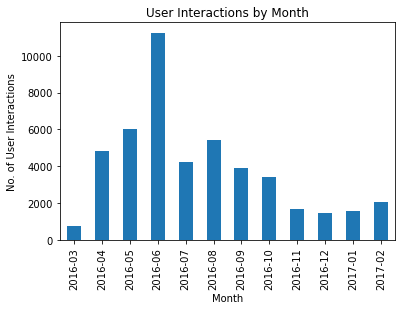

In [98]:
interactionswitharticlesDF['articleInteractedTime'] = interactionswitharticlesDF['articleInteractedTime'].apply(lambda x: to_datetime(x))
interactionswitharticlesDF['month_x'] = interactionswitharticlesDF['articleInteractedTime'].apply(lambda x: '{0}-{1:02}'.format(x.year, x.month))
ploted = interactionswitharticlesDF.groupby('month_x').size().plot(kind='bar', title='User Interactions by Month')
interactionswitharticlesDF.drop('month_x', axis=1, inplace=True)
ploted.set_xlabel('Month')
ploted.set_ylabel('No. of User Interactions')
ploted

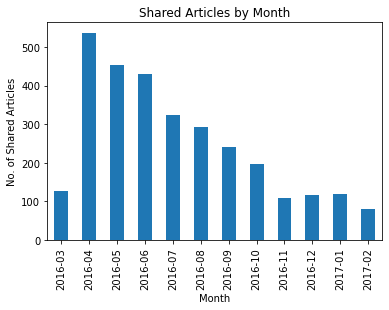

In [99]:
articlesDF['articlePublishedTime'] = articlesDF['articlePublishedTime'].apply(lambda y: to_datetime(y))
interactionswitharticlesDF['articlePublishedTime'] = interactionswitharticlesDF['articlePublishedTime'].apply(lambda y: to_datetime(y))
articlesDF['month_y'] = articlesDF['articlePublishedTime'].apply(lambda y: '{0}-{1:02}'.format(y.year, y.month))
ploted = articlesDF.groupby('month_y').size().plot(kind='bar', title='Shared Articles by Month')
articlesDF.drop('month_y', axis=1, inplace=True)
ploted.set_xlabel('Month')
ploted.set_ylabel('No. of Shared Articles')
ploted

### 13.Main Domains on Shared Articles
Domains of the article are seperated

In [100]:
urlDomainsDF = pd.DataFrame(interactionswitharticlesDF['url'])
urlDomainsDF['urlDomain'] = interactionswitharticlesDF['url'].apply(lambda x: re.sub(r'^http[s]*:\/\/', '', re.search(r'^http[s]*:\/\/[\w\.]*', x, re.IGNORECASE).group(0)))
urlDomainsDF[['urlDomain','url']]

,urlDomain,url
0,techcrunch.com,http://techcrunch.com/2016/06/07/hiri/
1,techcrunch.com,http://techcrunch.com/2016/06/07/hiri/
2,techcrunch.com,http://techcrunch.com/2016/06/07/hiri/
3,techcrunch.com,http://techcrunch.com/2016/06/07/hiri/
4,techcrunch.com,http://techcrunch.com/2016/06/07/hiri/
...,...,...
71564,techcrunch.com,https://techcrunch.com/2016/12/28/the-eye-trib...
71565,techcrunch.com,https://techcrunch.com/2016/12/28/the-eye-trib...
71566,nautil.us,http://nautil.us/blog/copyrighting-dna-is-a-ba...
71568,www.smashingmagazine.com,https://www.smashingmagazine.com/2016/12/digit...


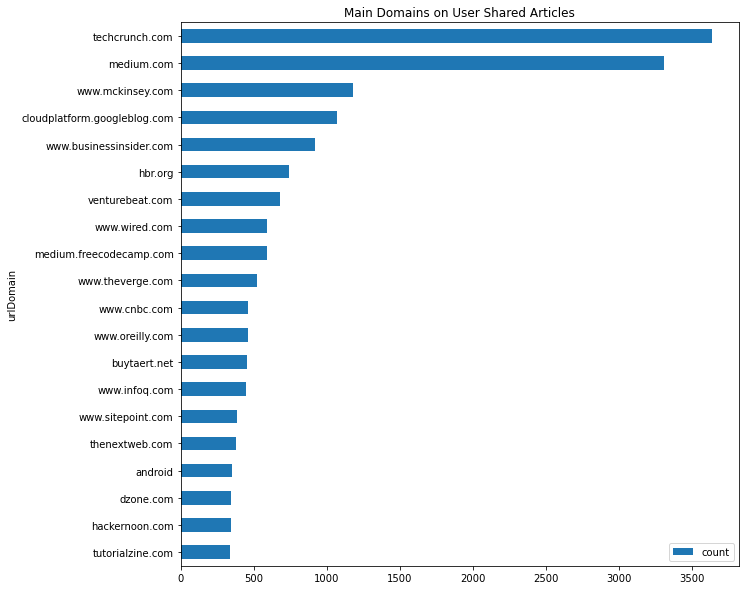

In [101]:
main_domains_df = pd.DataFrame(urlDomainsDF.groupby('urlDomain').size().sort_values(ascending=True))[-20:].reset_index()
main_domains_df.columns = ['urlDomain','count']
main_domains_df['count']
main_domains_df.plot(kind='barh', x='urlDomain', y='count', figsize=(10,10), title='Main Domains on User Shared Articles')

## Dataset Copy for KMeans
We clean the text and title and store it in a seperate database for KMeans

In [102]:
#take out only english articles
english_articles_df = pd.DataFrame(articlesDF[articlesDF['lang'] == 'en'])
english_articles_df.drop(['authorRegion', 'authorCountry', 'authorUserAgent'], axis=1, inplace=True)

In [103]:
articlescopy_df = english_articles_df.copy()
articlescopy_df['AnalysisText']= articlescopy_df['title']+":"+articlescopy_df['text']
# removing everything except alphabets`
articlescopy_df['CleanText'] = articlescopy_df['AnalysisText'].str.replace("[^a-zA-Z#]", " ")
# removing short words
articlescopy_df['CleanText'] = articlescopy_df['CleanText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# make all text lowercase
articlescopy_df['CleanText'] = articlescopy_df['CleanText'].apply(lambda x: x.lower())
articlescopy_df.drop(columns=['AnalysisText'],inplace=True)
articlescopy_df.rename(inplace = True, columns={"CleanText":"AnalysisText"})

## Feature Extraction
Feature extraction is one of stages in the information retrieval system that used to extract the unique feature values of a text document. The process of feature extraction can be done by several methods, one of which is Latent Dirichlet Allocation. Words are modeled by a set of topics and documents are modeled by a set of topics. An example is as follows
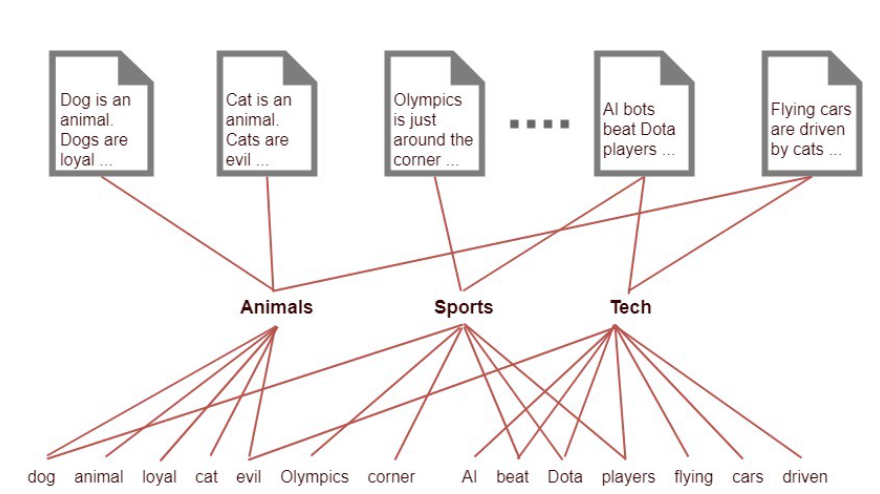

In [104]:
#FeatureExtraction with Latent Dirchlet Allocation
english_articles_content_df = (english_articles_df['title'] + ':' + english_articles_df['text']).tolist()

### Data Pre-Processing for Feature Extraction

1. Tokenization: Split the text into sentences and the sentences into words. Lowercase the words  and remove punctuation.
2. All stopwords are removed.
3. Bigrams (set of two words that occur frequently together) are processed from the unigrams.

In [105]:
#Loading a set of English stopwords
english_stopset = set(stopwords.words('english')).union(
                 {"things", "that's", "something", "take", "don't", "may", "want", "you're", 
                  "set", "might", "says", "including", "lot", "much", "said", "know", 
                  "good", "step", "often", "going", "thing", "things", "think","go", "write", "i'm",
                  "back", "actually", "better", "look", "find", "right", "example",  
                  "verb", "verbs", "really"})

In [106]:
#Tokenizing words of articles
tokenizer = RegexpTokenizer(r"(?u)[\b\#a-zA-Z][\w&-_]+\b")
english_articles_tokens = list(map(lambda d: [token for token in tokenizer.tokenize(d.lower()) if token not in english_stopset], english_articles_content_df))

In [107]:
#Processing bigrams from unigrams (sets of two words that frequently occur together)
bigram_transformer = models.Phrases(english_articles_tokens)
english_articles_unigrams_bigrams_tokens = list(bigram_transformer[english_articles_tokens])

### Bag of words on the dataset
A dictionary is created which contains the list of unique tokens in the corpus and the creation of the dictionary requires to specify two important parameters.

<h3>[Gensim filter_extremes] :</h3>
no_below - This parameter filters out words which are too rare to be informative. Filter out tokens that appear in less than no_below documents (absolute number)

no_above - This parameter filters out words which are too frequent to be informative. Filter out tokens that appear in more than no_above documents (fraction of total corpus size)

<h3>[Gensim doc2bow] :</h3>
For each document we create a dictionary reporting how many words and how many times those words appear. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.


In [108]:
#Creating a dictionary and filtering out too rare and too common tokens
english_dictionary = corpora.Dictionary(english_articles_unigrams_bigrams_tokens)
english_dictionary.filter_extremes(no_below=5, no_above=0.4, keep_n=None)
english_dictionary.compactify()
print(english_dictionary)

Dictionary(16311 unique tokens: ['actual', 'advocates', 'agreed_upon', 'agreements', 'aim']...)


In [109]:
#Processing Bag-of-Words (BoW) for each article
english_articles_bow = [english_dictionary.doc2bow(doc) for doc in english_articles_unigrams_bigrams_tokens]

### Running LDA through Bag of Words :

We are going for 5 categories in the document corpus.
Some of the parameters we will be tweaking are :
1. num_topics is the number of requested latent topics to be extracted from the training corpus.
2. id2word is a mapping from word ids (integers) to words (strings). It is used to determine the vocabulary size, as well as for debugging and topic printing
3. Passes is the number of training passes through the corpus.

In [110]:
#Training the LDA topic model on English articles
lda_model = models.LdaModel(english_articles_bow, id2word=english_dictionary, num_topics=5, passes=10, iterations=500)

In [111]:
#Processing the topics for each article
english_articles_lda = lda_model[english_articles_bow]

In [112]:
# Top 5 Keywords for each Category
topic_top5words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 5]

df_top5words_stacked = pd.DataFrame(topic_top5words, columns=['topic_id', 'words'])
df_top5words = df_top5words_stacked.groupby('topic_id').agg(', '.join)
df_top5words.reset_index(level=0,inplace=True)
df_top5words.columns = ['CategoryID', 'Keywords']
df_top5words

,CategoryID,Keywords
0,0,"team, software, project, change, teams"
1,1,"code, api, app, page, content"
2,2,"google, company, product, platform, companies"
3,3,"machine_learning, ai, google, apple, research"
4,4,"technology, companies, customers, digital, blo..."


### Defining Categories
Categories inferred using the keywords in each category and their corresponding weights (Category Classification)
0: Software Development
1: Programming
2: Companies 
3: Machine Learning
4: Information Technology

In [113]:
for idX, topic in lda_model.print_topics(-1):
    print("Category: {} \nWords: {}".format(idX, topic))
    print("\n")

Category: 0 
Words: 0.012*"team" + 0.006*"software" + 0.006*"project" + 0.005*"change" + 0.004*"teams" + 0.004*"design" + 0.004*"users" + 0.003*"system" + 0.003*"service" + 0.003*"process"


Category: 1 
Words: 0.008*"code" + 0.005*"api" + 0.004*"app" + 0.004*"page" + 0.004*"content" + 0.003*"create" + 0.003*"file" + 0.003*"java" + 0.003*"application" + 0.003*"version"


Category: 2 
Words: 0.006*"google" + 0.005*"company" + 0.004*"product" + 0.004*"platform" + 0.004*"companies" + 0.003*"growth" + 0.003*"best" + 0.003*"content" + 0.003*"users" + 0.003*"business"


Category: 3 
Words: 0.005*"machine_learning" + 0.005*"ai" + 0.005*"google" + 0.004*"apple" + 0.003*"research" + 0.002*"company" + 0.002*"computer_science" + 0.002*"book" + 0.002*"deep_learning" + 0.002*"ibm"


Category: 4 
Words: 0.006*"technology" + 0.004*"companies" + 0.004*"customers" + 0.004*"digital" + 0.003*"blockchain" + 0.003*"information" + 0.003*"world" + 0.003*"business" + 0.003*"drupal" + 0.003*"google"




### Adding Target Feature to the Current Dataset

Target Feature 'categoryID' has been added to the dataset for all the interactions with articles with their respective percent contribution & keywords

In [114]:
def format_topics_sentences(ldamodel=None, corpus=english_articles_bow, texts=english_articles_unigrams_bigrams_tokens):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the CategoryID, Percent Contribution and Keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([(round(topic_num,0)), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['CategoryID', 'PercentContribution', 'Keywords']

    # Add original text to the end of the output
    return(sent_topics_df)


df_topic_sent_keywords = format_topics_sentences(ldamodel=lda_model, corpus=english_articles_bow, texts=english_articles_unigrams_bigrams_tokens)

# Format
df_topic_sent_keywords.reset_index(drop=True, inplace=True)
english_articles_df.reset_index(drop=True, inplace=True)
english_articles_df = pd.concat([english_articles_df, df_topic_sent_keywords], axis = 1)

In [115]:
english_articles_df

,articlePublishedTime,contentId,authorPersonId,authorSessionId,url,title,text,lang,viewCount,likeCount,commentcreatedCount,bookmarkCount,followCount,interactionCount,CategoryID,PercentContribution,Keywords
0,2016-03-28 16:39:48,-4110354420726924665,4340306774493623681,8940341205206233829,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,1,0,0,0,0,1,4.0,0.6691,"technology, companies, customers, digital, blo..."
1,2016-03-28 16:42:26,-7292285110016212249,4340306774493623681,8940341205206233829,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,1,0,0,0,0,1,4.0,0.5718,"technology, companies, customers, digital, blo..."
2,2016-03-28 16:47:54,-6151852268067518688,3891637997717104548,-1457532940883382585,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,10,3,0,0,0,13,2.0,0.3875,"google, company, product, platform, companies,..."
3,2016-03-28 16:48:17,2448026894306402386,4340306774493623681,8940341205206233829,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,0,0,0,0,0,0,4.0,0.5911,"technology, companies, customers, digital, blo..."
4,2016-03-28 16:48:42,-2826566343807132236,4340306774493623681,8940341205206233829,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,2,0,0,0,0,2,4.0,0.5139,"technology, companies, customers, digital, blo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,2017-02-24 08:35:56,4675505028897335428,-1393866732742189886,-1729556941184852519,https://medium.mybridge.co/swift-top-10-articl...,Swift Top 10 Articles For The Past Year (v.2017),"For the past year , we've ranked nearly 9,000 ...",en,9,3,1,2,2,17,3.0,0.8754,"machine_learning, ai, google, apple, research,..."
2195,2017-02-24 10:37:47,-3295913657316686039,6960073744377754728,-8193630595542572738,https://thenextweb.com/apps/2017/02/14/amazon-...,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",en,3,0,0,0,0,3,3.0,0.5587,"machine_learning, ai, google, apple, research,..."
2196,2017-02-27 15:20:24,3618271604906293310,1908339160857512799,-183341653743161643,https://code.org/about/2016,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",en,1,0,0,0,0,1,3.0,0.9115,"machine_learning, ai, google, apple, research,..."
2197,2017-02-28 12:51:59,6607431762270322325,-1393866732742189886,2367029511384577082,https://www.bloomberg.com/news/articles/2017-0...,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",en,1,0,0,0,0,1,4.0,0.9983,"technology, companies, customers, digital, blo..."


### Feature Importance

It is another type of feature selection. You can get the feature importance of each feature of your dataset by using the feature importance property of the model.

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top features for the dataset.

In [116]:
from sklearn.ensemble import ExtraTreesClassifier

In [117]:
X = interactionswitharticlesDF.iloc[:,[2,3,4,6,7]] 
y = interactionswitharticlesDF.iloc[:,-3] 
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

In [118]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[0.34998996 0.02663563 0.0243674  0.27492507 0.32408193]


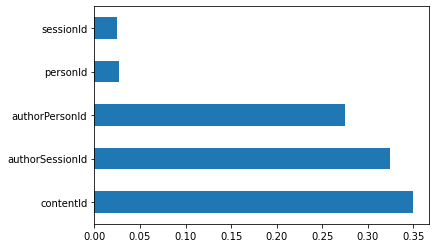

In [119]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Visualizing the Distribution of Categories

In [120]:
english_articles_df.CategoryID = english_articles_df.CategoryID.astype(int)

In [121]:
english_articles_df["CategoryID"].value_counts()

3    686
1    498
2    397
4    390
0    228
Name: CategoryID, dtype: int64

In [122]:
Category = ["Machine Learning","Programming", "Companies","Information Technology", "Software Development"]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E56962A588>],
      dtype=object)

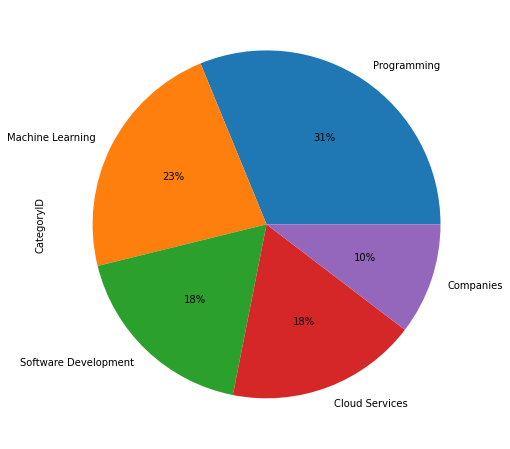

In [123]:
english_articles_df["CategoryID"].value_counts().plot(kind='pie', labels=Category, autopct='%1.0f%%', subplots=True, figsize=(8, 8))

## Models

### K Means Clustering
Since the original dataset had no categories and class labels, we decided to implement unsupervised learning in our model

In [124]:
vectorizer = TfidfVectorizer(stop_words='english',max_df = 0.5, smooth_idf=True)
X = vectorizer.fit_transform(articlescopy_df['AnalysisText'])

In [125]:
kmeans_model=KMeans(n_clusters=56)
kmeans_model.fit(X)

KMeans(n_clusters=56)

In [126]:
Y=kmeans_model.predict(X)

In [127]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, kmeans_model.labels_, sample_size=1000))

Silhouette Coefficient: 0.019


Because the Silhouette Coefficient is very low, KMeans algorithm cannot be used to cluster unseen data, hence we try another model for the same

### Logistic Regression
As we have used LDA to do semantic analysis and find categories of the data, we can use a supervised learning aglorithm like Logistic Regression.

In [128]:
X = english_articles_df['text'] + "  " + english_articles_df['title']
y = english_articles_df['CategoryID']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [129]:
#Calculating the number of rows in our train set
len(y_train)

1539

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E5696EDBC8>],
      dtype=object)

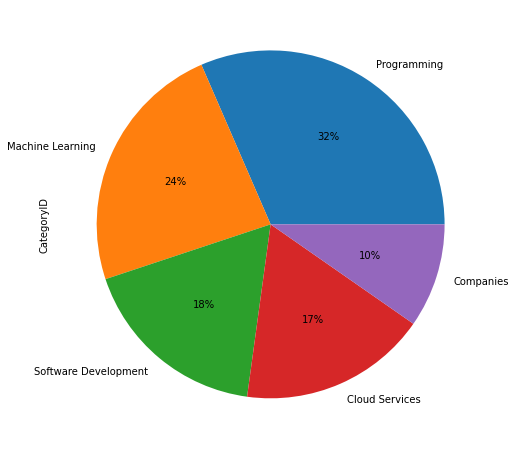

In [130]:
y_train.value_counts().plot(kind='pie', labels=Category, autopct='%1.0f%%', subplots=True, figsize=(8, 8))

### Training the Logistic Regression Classifier

In order to train and test the classifier, the first step should be to tokenize and count the number of occurrence of each word that appear in the articles.

We use the CountVectorizer() for that. Each term is assigned a unique integer index.

Then the counters are transformed to a TF-IDF representation using TfidfTransformer().

The last step creates the Logistic Regression classifier. It is worth noting that the default mode for the LogisticRegression() function can only help us classify binary target variables. In order to be able to classify a multi-class problem, we specify multi_class=’multinomial’. Also worth noting is that the only solvers that can be used for a multiclass problem are: newton-cg, sag & lbfgs which are specified using the solver=newton_cg parameter in the LogisticRegression() function.

In order to make the training process easier, scikit-learn provides a Pipeline class that behaves like a compound classifier.

In [131]:
text_np = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf2', LogisticRegression(solver='newton-cg', multi_class='multinomial')),
                         ])

In [132]:
text_np = text_np.fit(X_train, y_train)
predicted2 = text_np.predict(X_test)

In [133]:
metrics.accuracy_score(y_test, predicted2)

0.7742424242424243

In [152]:
print(metrics.classification_report(y_test, predicted2, target_names=sorted(Category)))

                      precision    recall  f1-score   support

      Cloud Services       0.97      0.41      0.57        79
           Companies       0.78      0.89      0.83       135
    Machine Learning       0.77      0.60      0.68       124
         Programming       0.73      0.94      0.82       201
Software Development       0.81      0.79      0.80       121

            accuracy                           0.77       660
           macro avg       0.81      0.73      0.74       660
        weighted avg       0.79      0.77      0.76       660



In [135]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [153]:
cnf_matrix = confusion_matrix(y_test, predicted2)

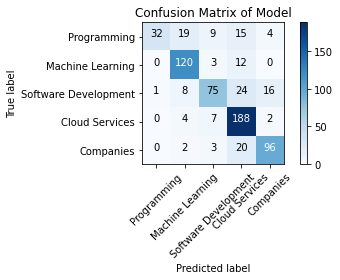

In [137]:
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=Category,title='Confusion Matrix of Model')

We can see from the metrics that the precision an f1-score are really good for our trained model.

The overall accuracy of classification is 77.42%

## Conclusion
***
Only useful feature for document classification is the text and title of the article. NLP is used since models don't understand text data. Once the input is inline with the models, we decided which model to use. KMeans is used since our dataset is not labeled. But since KMeans isn't providing good results (Silhouette Coefficient of 0.019), we moved on to supervised classification i.e. Logistic Regression. 

This algorithm was chosen as it allows multinomial classification and proper solver was chosen according to the problem. We used NLP to get the labels. The algorithm showed good accuracy (77.42%) and precision, recall and f1-score are also in high standing. This proves that logistic regression can be clearly used for classifying documents into categories. 

In [155]:
unseen_text_data = ['Machine Learning is Fun Have you heard people talking about machine learning but only have a fuzzy idea of what that means? Are you tired of nodding your way through conversations with co-workers? Let’s change that! This guide is for anyone who is curious about machine learning but has no idea where to start. I imagine there are a lot of people who tried reading the wikipedia article, got frustrated and gave up wishing someone would just give them a high-level explanation. That’s what this is. The goal is be accessible to anyone — which means that there’s a lot of generalizations. But who cares? If this gets anyone more interested in ML, then mission accomplished.What is machine learning? Machine learning is the idea that there are generic algorithms that can tell you something interesting about a set of data without you having to write any custom code specific to the problem. Instead of writing code, you feed data to the generic algorithm and it builds its own logic based on the data. For example, one kind of algorithm is a classification algorithm. It can put data into different groups. The same classification algorithm used to recognize handwritten numbers could also be used to classify emails into spam and not-spam without changing a line of code. It’s the same algorithm but it’s fed different training data so it comes up with different classification logic. “Machine learning” is an umbrella term covering lots of these kinds of generic algorithms. Two kinds of Machine Learning Algorithms You can think of machine learning algorithms as falling into one of two main categories — supervised learning and unsupervised learning. The difference is simple, but really important. Supervised Learning Let’s say you are a real estate agent. Your business is growing, so you hire a bunch of new trainee agents to help you out. But there’s a problem — you can glance at a house and have a pretty good idea of what a house is worth, but your trainees don’t have your experience so they don’t know how to price their houses. To help your trainees (and maybe free yourself up for a vacation), you decide to write a little app that can estimate the value of a house in your area based on it’s size, neighborhood, etc, and what similar houses have sold for. So you write down every time someone sells a house in your city for 3 months. For each house, you write down a bunch of details — number of bedrooms, size in square feet, neighborhood, etc. But most importantly, you write down the final sale price:Using that training data, we want to create a program that can estimate how much any other house in your area is worth: This is called supervised learning. You knew how much each house sold for, so in other words, you knew the answer to the problem and could work backwards from there to figure out the logic. To build your app, you feed your training data about each house into your machine learning algorithm. The algorithm is trying to figure out what kind of math needs to be done to make the numbers work out. This kind of like having the answer key to a math test with all the arithmetic symbols erased: From this, can you figure out what kind of math problems were on the test? You know you are supposed to “do something” with the numbers on the left to get each answer on the right. In supervised learning, you are letting the computer work out that relationship for you. And once you know what math was required to solve this specific set of problems, you could answer to any other problem of the same type! Unsupervised Learning Let’s go back to our original example with the real estate agent. What if you didn’t know the sale price for each house? Even if all you know is the size, location, etc of each house, it turns out you can still do some really cool stuff. This is called unsupervised learning. This is kind of like someone giving you a list of numbers on a sheet of paper and saying “I don’t really know what these numbers mean but maybe you can figure out if there is a pattern or grouping or something — good luck!” So what could do with this data? For starters, you could have an algorithm that automatically identified different market segments in your data. Maybe you’d find out that home buyers in the neighborhood near the local college really like small houses with lots of bedrooms, but home buyers in the suburbs prefer 3-bedroom houses with lots of square footage. Knowing about these different kinds of customers could help direct your marketing efforts. Another cool thing you could do is automatically identify any outlier houses that were way different than everything else. Maybe those outlier houses are giant mansions and you can focus your best sales people on those areas because they have bigger commissions. Supervised learning is what we’ll focus on for the rest of this post, but that’s not because unsupervised learning is any less useful or interesting. In fact, unsupervised learning is becoming increasingly important as the algorithms get better because it can be used without having to label the data with the correct answer. Side note: There are lots of other types of machine learning algorithms. But this is a pretty good place to start. That’s cool, but does being able to estimate the price of a house really count as “learning”? As a human, your brain can approach most any situation and learn how to deal with that situation without any explicit instructions. If you sell houses for a long time, you will instinctively have a “feel” for the right price for a house, the best way to market that house, the kind of client who would be interested, etc. The goal of Strong AI research is to be able to replicate this ability with computers. But current machine learning algorithms aren’t that good yet — they only work when focused a very specific, limited problem. Maybe a better definition for “learning” in this case is “figuring out an equation to solve a specific problem based on some example data”. Unfortunately “Machine Figuring out an equation to solve a specific problem based on some example data” isn’t really a great name. So we ended up with “Machine Learning” instead. Of course if you are reading this 50 years in the future and we’ve figured out the algorithm for Strong AI, then this whole post will all seem a little quaint. Maybe stop reading and go tell your robot servant to go make you a sandwich, future human. Let’s write that program! So, how would you write the program to estimate the value of a house like in our example above? Think about it for a second before you read further. If you didn’t know anything about machine learning, you’d probably try to write out some basic rules for estimating the price of a house like this:']
actual_unseen = [1] #the id for machine learning category
predicted_unseen = text_np.predict(unseen_text_data)
Class_Labels  = ['Software Development','Programming','Companies','Machine Learning','Information Technology']
Class_Labels[predicted_unseen[0]]
#metrics.accuracy_score(actual_unseen,predicted_unseen)

'Machine Learning'

As you can see from above, our model performs well with unseen data as well